In [1]:
%matplotlib inline
from __future__ import division, print_function

Let's try desining my own Second Order Kalman Filter for vehicle tracking by start following the chapter 08. 

# Design Considerations

## ~ Prediction Step ~

### Design State Variables(x)

A vector x of state variables. A pair of observed variables (x,y) and their hidden variables. 

$$\mathbf x = 
\begin{bmatrix}x & \dot x & \ddot x & y & \dot y & \ddot y\end{bmatrix}^\mathsf T$$

### Design State Covariance(P)

A state covariance matrix just need to have large enough values that will be updated as the filter sees more observations.

$$\mathbf P = \begin{bmatrix}
100 & 0 & 0 & 0 & 0 & 0\\ 
0 & 100 & 0 & 0 & 0 & 0 \\
0 & 0 & 100 & 0 & 0 & 0 \\
0 & 0 & 0 & 100 & 0 & 0 \\ 
0 & 0 & 0 & 0 & 100 & 0 \\
0 & 0 & 0 & 0 & 0 & 100 \\
\end{bmatrix}$$

### Design Process Model(F)

Equations of x.

$$\begin{aligned} x_t &= x_{t-1} + \dot x_{t-1}\Delta t + 0.5\ddot x_{t-1} \Delta t^2 \\
 \dot x_t &= \dot x_{t-1} + \ddot x_{t-1}\Delta t \\
 \ddot x_t &= \ddot x_{t-1}\end{aligned}$$
 
Equatinos of y.
 
$$\begin{aligned} y_t &= y_{t-1} + \dot y_{t-1}\Delta t + 0.5\ddot y_{t-1} \Delta t^2 \\
 \dot y_t &= \dot y_{t-1} + \ddot y_{t-1}\Delta t \\
 \ddot y_t &= \ddot y_{t-1}\end{aligned}$$
 
In video, another factor, distortion, should be considered. The system could take this into account as a measurement function H, but may be not. The effects of distortion can be seen as another accelaration. At first, let's assume this effect is seen as an additional speed.

$$\begin{aligned}\dot x_t &= \dot x_{t-1}*distortion_x + \ddot x_{t-1}\Delta t\end{aligned}$$
$$\begin{aligned}\dot y_t &= \dot y_{t-1}*distortion_y + \ddot y_{t-1}\Delta t\end{aligned}$$

When distortion factor is 1.05, a vehicle speed is increased by 5% more.

The state transition function F has to meet the following.

$$\begin{bmatrix}x_t\\\dot x_t\\\ddot{x_t} \\y_t\\\dot y_t\\\ddot{y_t}\end{bmatrix} = \mathbf F\begin{bmatrix}x_{t-1}\\\dot x_{t-1}\\\ddot{x}_{t-1} \\y_{t-1}\\\dot y_{t-1}\\\ddot{y}_{t-1}\end{bmatrix}$$

which is,

$$\mathbf F = \begin{bmatrix}
1 & \Delta t &.5\Delta t^2 & 0 & 0 & 0\\ 
0 & 1 & \Delta t & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & \\
0 & 0 & 0 & 1 & \Delta t &.5\Delta t^2 \\ 
0 & 0 & 0 & 0 & 1 & \Delta t\\
0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}$$

### Design Process Noise(Q)

White noise. Make this value smaller if predictions are more reliable than measurements.

## ~ Update Step ~

### Design Measurement Function(H)

Finally, the measurement function.

$$z = \mathbf{Hx}$$

Only a pair of positions (x,y) is measured.

$$\mathbf H = \begin{bmatrix}1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0\end{bmatrix}$$

### Design Measurement Noise(R)

Make this value smaller if measurements are more reliable than predictions.

In [2]:
import numpy as np
from scipy.linalg import block_diag
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def VehicleFilter(R_std, Q, dt, P):
    """ Create second order Kalman filter. 
    
    R_std: float, a standard deviation of measurement error
    Q    : float, a convariance of process noise
    dt   : a time unit
    P    : float, a maximum initial covariance
    """
    
    kf = KalmanFilter(dim_x=6, dim_z=2)
    kf.x = np.array([[0, 0, 0, 0, 0, 0]]).T
    kf.P = np.eye(6) * P
    print('initialized P = \n{}'.format(kf.P))
    kf.R = np.eye(2) * R_std**2
    print('initialized R = \n{}'.format(kf.R))
    q = Q_discrete_white_noise(3, dt, Q)
    kf.Q = block_diag(q, q)
    print('initialized Q = \n{}'.format(kf.Q))
    kf.F = np.array([[1., dt, .5*dt*dt, 0., 0., 0.],
                     [0., 1.,       dt, 0., 0., 0.],
                     [0., 0.,       1., 0., 0., 0.],
                     [0., 0.,       0., 1., dt, .5*dt*dt],
                     [ 0., 0.,      0., 0., 1., dt],
                     [ 0., 0.,      0., 0., 0., 1]])
    kf.H = np.array([[1., 0., 0., 0., 0., 0.],
                     [0., 0., 0., 1., 0., 0.]])
    print('no control function B: {}'.format(kf.B))
    return kf

In [3]:
from numpy.random import randn

class PosSensor(object):
    def __init__(self, pos=(0, 0), vel=(0, 0), accel=(0, 0), noise_std=.2, dist=(1., 1.)):
        self.pos = [pos[0], pos[1]]
        self.vel = [vel[0], vel[1]]
        self.accel = accel
        self.noise_std = noise_std
        # distortion
        self.dist = dist
        
    def read(self):
        # accelaration is constant
        # update velocity with the given distortion
        self.vel[0] = self.vel[0] * self.dist[0] + self.accel[0]
        self.vel[1] = self.vel[1] * self.dist[1] + self.accel[1]
        
        # update position
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

In [4]:
from filterpy.stats import plot_covariance_ellipse
from kf_book.book_plots import plot_filter

R_std = 1.
Q = .0001
dt = 1
P = 100

# simulate vehicle movement with no distortion
N =20
sensor = PosSensor(pos=(0, 0), vel=(1., 1.), accel=(0.1, 0.1), noise_std=R_std, dist=(1., 1.05))

zs = np.array([sensor.read() for _ in range(N)])

# create a filter
vehicle_tracker = VehicleFilter(R_std, Q, dt, P)
# run filter
mu, cov, _, _ = vehicle_tracker.batch_filter(zs)

print('==========================================')

for z, x, P in zip(zs, mu, cov):
    print('z: \n{}'.format(z))
    print('x: \n{}'.format(x))
    print('P: \n{}'.format(P))

initialized P = 
[[100.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0. 100.]]
initialized R = 
[[1. 0.]
 [0. 1.]]
initialized Q = 
[[2.5e-05 5.0e-05 5.0e-05 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 2.5e-05 5.0e-05 5.0e-05]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]]
no control function B: 0.0
z: 
[2.04517964 2.45926576]
x: 
[[2.03613017]
 [1.35742041]
 [0.45247377]
 [2.44838406]
 [1.6322564 ]
 [0.54408583]]
P: 
[[  0.99557522   0.66371696   0.22123913   0.           0.
    0.        ]
 [  0.66371696 100.44252252  66.81421872   0.           0.
    0.        ]
 [  0.22123913  66.81421872  88.9381322    0.           0.
    0.        ]
 [  0.           0.           0.           0.995575

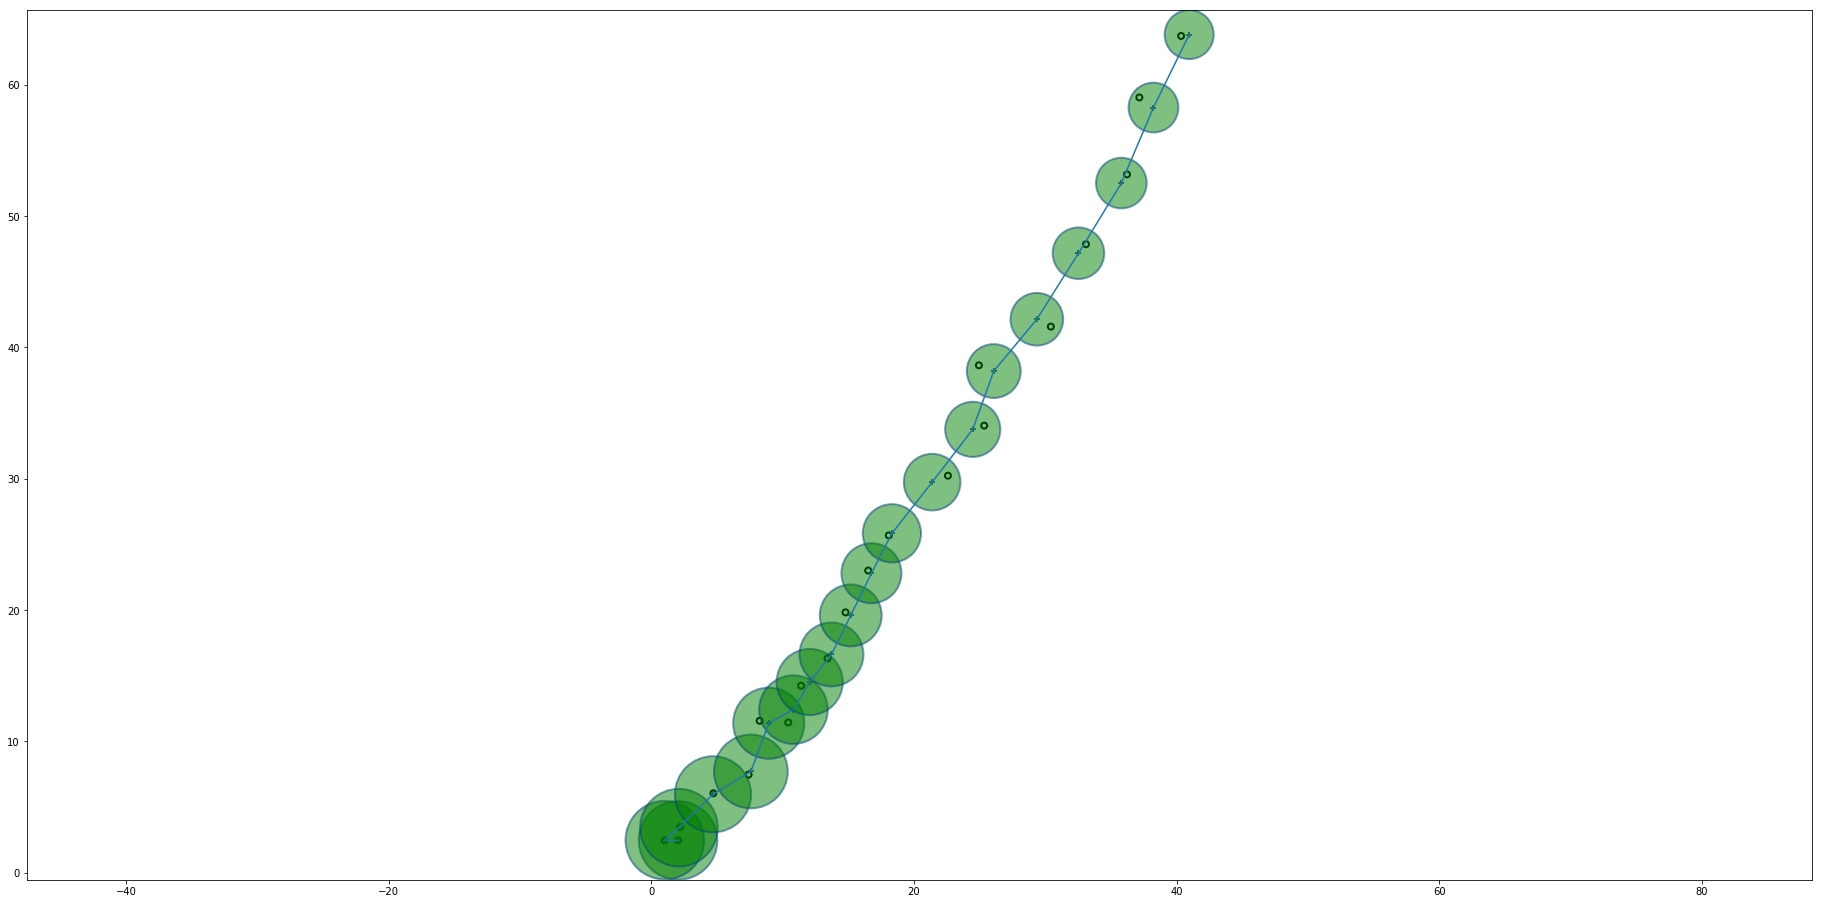

In [5]:
from kf_book.book_plots import set_figsize
from kf_book.book_plots import plot_measurements
from kf_book.book_plots import plot_filter
from filterpy.stats import plot_covariance_ellipse

# double the defaults
set_figsize(x=32, y=16)

plot_measurements(zs[:, 0], zs[:, 1]);
plot_filter(mu[:, 0], mu[:, 3])

for x, P in zip(mu, cov):
    # covariance of x and y
    cov = np.array([[P[0, 0], P[3, 0]], 
                    [P[0, 3], P[3, 3]]])
    mean = (x[0, 0], x[3, 0])
    plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)

Real Track Data
=======

Let's try real track data.

In [6]:
import pandas as pd

df = pd.read_csv('output/0000/0_centers.csv')
print(df)

         X      Y
0    192.0  163.0
1    193.0  163.0
2    193.0  163.0
3    193.0  163.0
4    192.0  163.0
5    193.0  163.0
6    193.0  163.0
7    192.0  163.0
8    193.0  163.0
9    193.0  163.0
10   193.0  163.0
11   193.0  163.0
12   193.0  163.0
13   193.0  163.0
14   193.0  163.0
15   193.0  163.0
16   193.0  163.0
17   193.0  163.0
18   193.0  163.0
19   193.0  163.0
20   193.0  163.0
21   193.0  164.0
22   193.0  164.0
23   194.0  163.0
24   193.0  164.0
25   193.0  164.0
26   193.0  164.0
27   193.0  164.0
28   193.0  164.0
29   193.0  164.0
..     ...    ...
310  344.0  196.0
311  349.0  196.0
312  353.0  199.0
313  358.0  200.0
314  366.0  200.0
315  373.0  203.0
316  380.0  204.0
317  387.0  206.0
318  395.0  207.0
319  401.0  209.0
320  417.0  212.0
321  415.0  214.0
322  420.0  214.0
323  430.0  217.0
324  439.0  219.0
325  449.0  220.0
326  459.0  223.0
327  465.0  225.0
328  476.0  226.0
329  486.0  226.0
330  590.0  248.0
331  646.0  260.0
332  704.0  272.0
333  764.0

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 2 columns):
X    340 non-null float64
Y    340 non-null float64
dtypes: float64(2)
memory usage: 5.4 KB
None


In [8]:
print(df.describe())

                X           Y
count  340.000000  340.000000
mean   232.276471  171.802941
std    117.757814   25.314063
min    191.000000  162.000000
25%    193.000000  163.000000
50%    193.000000  164.000000
75%    195.000000  164.000000
max    958.000000  327.000000


In [9]:
R_std = 10.
Q = 1.
dt = 1
P = 100.
vehicle_tracker = VehicleFilter(R_std, Q, dt, P)

# iterate over
zlist, xlist, cov = [], [], []
for index, row in df.iterrows():
    z = [row['X'], row['Y']]
    zlist.append(z)
    if index==0:
        # initialize
        vehicle_tracker.x = np.array([[z[0], 0, 0, z[1], 0, 0]]).T
    else:
        # predict
        vehicle_tracker.predict()
        vehicle_tracker.update(z)
        xlist.append(vehicle_tracker.x)
        cov.append(vehicle_tracker.P)
        
# this has to be a numpy array
zs = np.array(zlist)
mu = np.array(xlist)
    
print('==========================================')

for z, x, P in zip(zs, mu, cov):
    print('z: \n{}'.format(z))
    print('x: \n{}'.format(x))
    print('P: \n{}'.format(P))

initialized P = 
[[100.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0. 100.]]
initialized R = 
[[100.   0.]
 [  0. 100.]]
initialized Q = 
[[0.25 0.5  0.5  0.   0.   0.  ]
 [0.5  1.   1.   0.   0.   0.  ]
 [0.5  1.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.25 0.5  0.5 ]
 [0.   0.   0.   0.5  1.   1.  ]
 [0.   0.   0.   0.5  1.   1.  ]]
no control function B: 0.0
z: 
[192. 163.]
x: 
[[1.92692544e+02]
 [4.62720984e-01]
 [1.55265181e-01]
 [1.63000000e+02]
 [0.00000000e+00]
 [0.00000000e+00]]
P: 
[[ 69.25441968  46.27209839  15.52651806   0.           0.
    0.        ]
 [ 46.27209839 131.36049193  77.63259032   0.           0.
    0.        ]
 [ 15.52651806  77.63259032  93.15910838   0.           0.
    0.        ]
 [  0.           0.           0.          69.25441968  46.27209839
   15.52651806]
 [  0.           0.           0.          46.27209839 13

 [ 0.          0.          0.          6.28682152  7.42635695  3.38622103]]
z: 
[192. 163.]
x: 
[[ 1.91282703e+02]
 [-3.07975745e-01]
 [-3.06403972e-02]
 [ 1.62878115e+02]
 [-2.23339619e-01]
 [-1.77149228e-02]]
P: 
[[60.47587512 27.57538879  6.28682152  0.          0.          0.        ]
 [27.57538879 22.57364305  7.42635695  0.          0.          0.        ]
 [ 6.28682152  7.42635695  3.38622103  0.          0.          0.        ]
 [ 0.          0.          0.         60.47587512 27.57538879  6.28682152]
 [ 0.          0.          0.         27.57538879 22.57364305  7.42635695]
 [ 0.          0.          0.          6.28682152  7.42635695  3.38622103]]
z: 
[191. 163.]
x: 
[[ 1.90983956e+02]
 [-3.27422576e-01]
 [-2.80884130e-02]
 [ 1.62860052e+02]
 [-1.43415157e-01]
 [ 4.54555708e-03]]
P: 
[[60.47587512 27.57538879  6.28682152  0.          0.          0.        ]
 [27.57538879 22.57364305  7.42635695  0.          0.          0.        ]
 [ 6.28682152  7.42635695  3.38622103  0.    

P: 
[[60.47587512 27.57538879  6.28682152  0.          0.          0.        ]
 [27.57538879 22.57364305  7.42635695  0.          0.          0.        ]
 [ 6.28682152  7.42635695  3.38622103  0.          0.          0.        ]
 [ 0.          0.          0.         60.47587512 27.57538879  6.28682152]
 [ 0.          0.          0.         27.57538879 22.57364305  7.42635695]
 [ 0.          0.          0.          6.28682152  7.42635695  3.38622103]]
z: 
[251. 175.]
x: 
[[2.56077148e+02]
 [4.25617158e+00]
 [3.07510571e-01]
 [1.75290518e+02]
 [1.04013595e+00]
 [6.30446064e-02]]
P: 
[[60.47587512 27.57538879  6.28682152  0.          0.          0.        ]
 [27.57538879 22.57364305  7.42635695  0.          0.          0.        ]
 [ 6.28682152  7.42635695  3.38622103  0.          0.          0.        ]
 [ 0.          0.          0.         60.47587512 27.57538879  6.28682152]
 [ 0.          0.          0.         27.57538879 22.57364305  7.42635695]
 [ 0.          0.          0.        

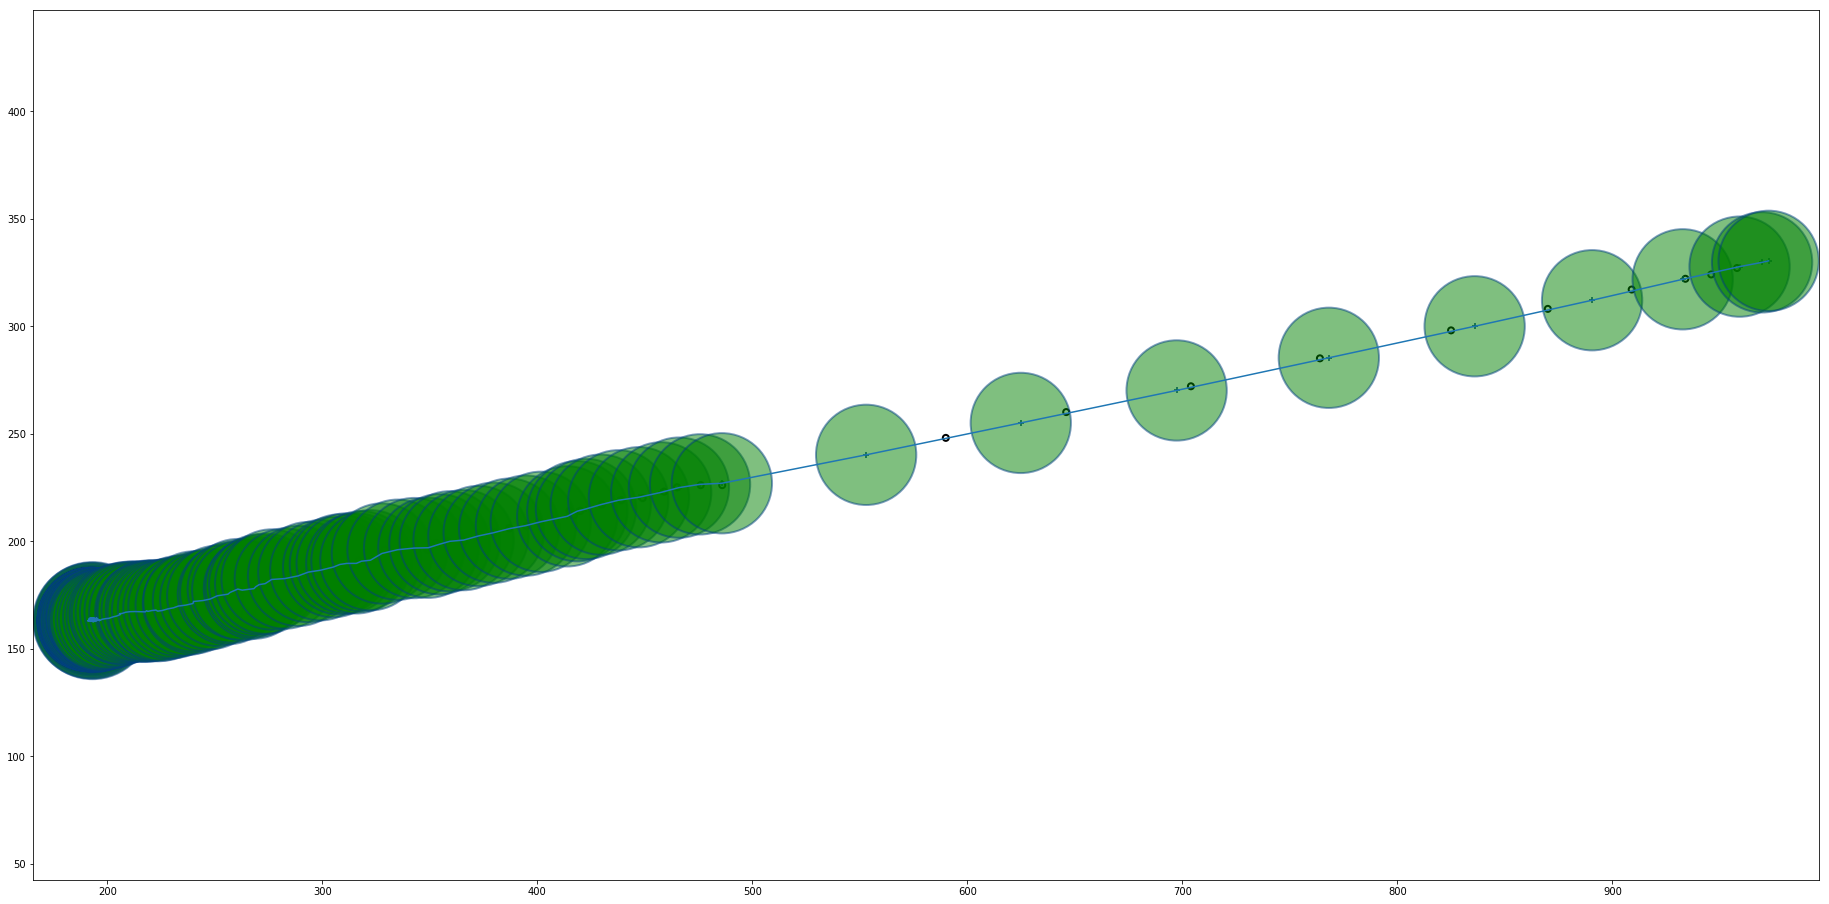

In [10]:
# plot
plot_measurements(zs[:, 0], zs[:, 1]);
plot_filter(mu[:, 0], mu[:, 3])

for x, P in zip(mu, cov):
    # covariance of x and y
    cov = np.array([[P[0, 0], P[3, 0]], 
                    [P[0, 3], P[3, 3]]])
    mean = (x[0, 0], x[3, 0])
    plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)

In [19]:
def filter_and_plot(csv):
    df = pd.read_csv(csv)
    R_std = 10.
    Q = .0001
    dt = 1
    P = 100.
    vehicle_tracker = VehicleFilter(R_std, Q, dt, P)

    # iterate over
    zlist, xlist, cov = [], [], []
    for index, row in df.iterrows():
        z = [row['X'], row['Y']]
        zlist.append(z)
        if index==0:
            # initialize
            vehicle_tracker.x = np.array([[z[0], 0, 0, z[1], 0, 0]]).T
        else:
            # predict
            vehicle_tracker.predict()
            vehicle_tracker.update(z)
            xlist.append(vehicle_tracker.x)
            cov.append(vehicle_tracker.P)
        
    # this has to be a numpy array
    zs = np.array(zlist)
    mu = np.array(xlist)
    
    # plot
    plot_measurements(zs[:, 0], zs[:, 1]);
    plot_filter(mu[:, 0], mu[:, 3])

    for x, P in zip(mu, cov):
        # covariance of x and y
        cov = np.array([[P[0, 0], P[3, 0]], 
                        [P[0, 3], P[3, 3]]])
        mean = (x[0, 0], x[3, 0])
        plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)

initialized P = 
[[100.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0. 100.]]
initialized R = 
[[100.   0.]
 [  0. 100.]]
initialized Q = 
[[2.5e-05 5.0e-05 5.0e-05 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 2.5e-05 5.0e-05 5.0e-05]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]]
no control function B: 0.0


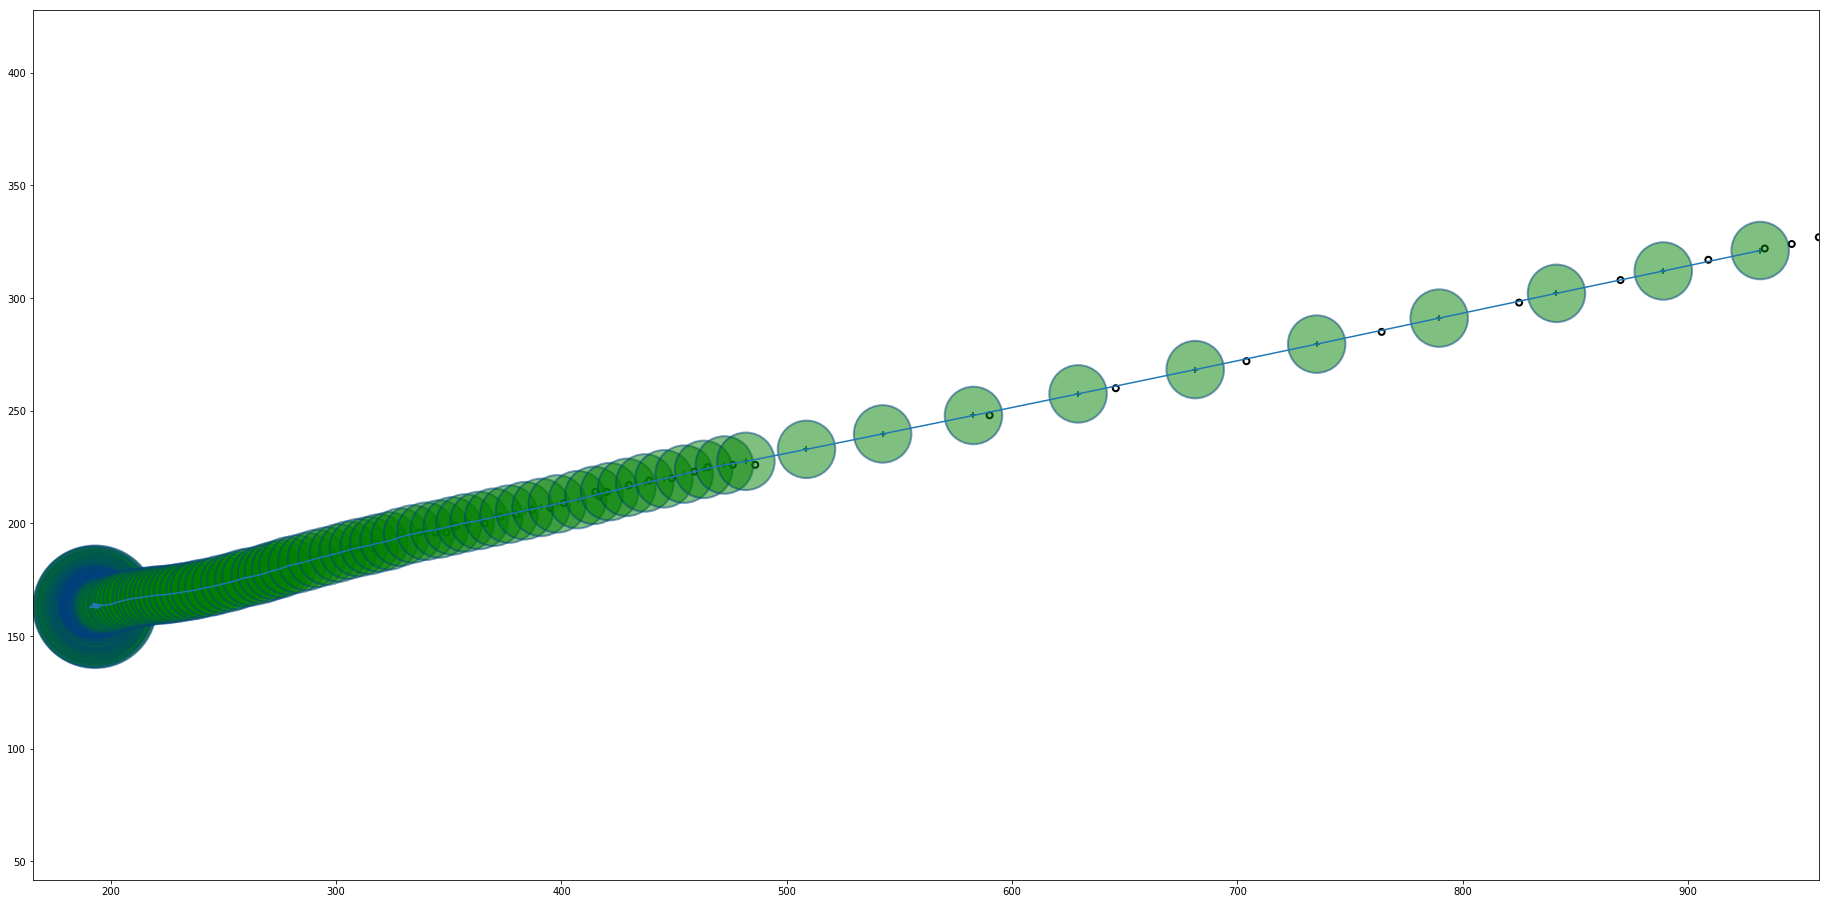

In [20]:
filter_and_plot('output/0000/0_centers.csv')

initialized P = 
[[100.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0. 100.]]
initialized R = 
[[1. 0.]
 [0. 1.]]
initialized Q = 
[[2.5e-05 5.0e-05 5.0e-05 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 2.5e-05 5.0e-05 5.0e-05]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]]
no control function B: 0.0


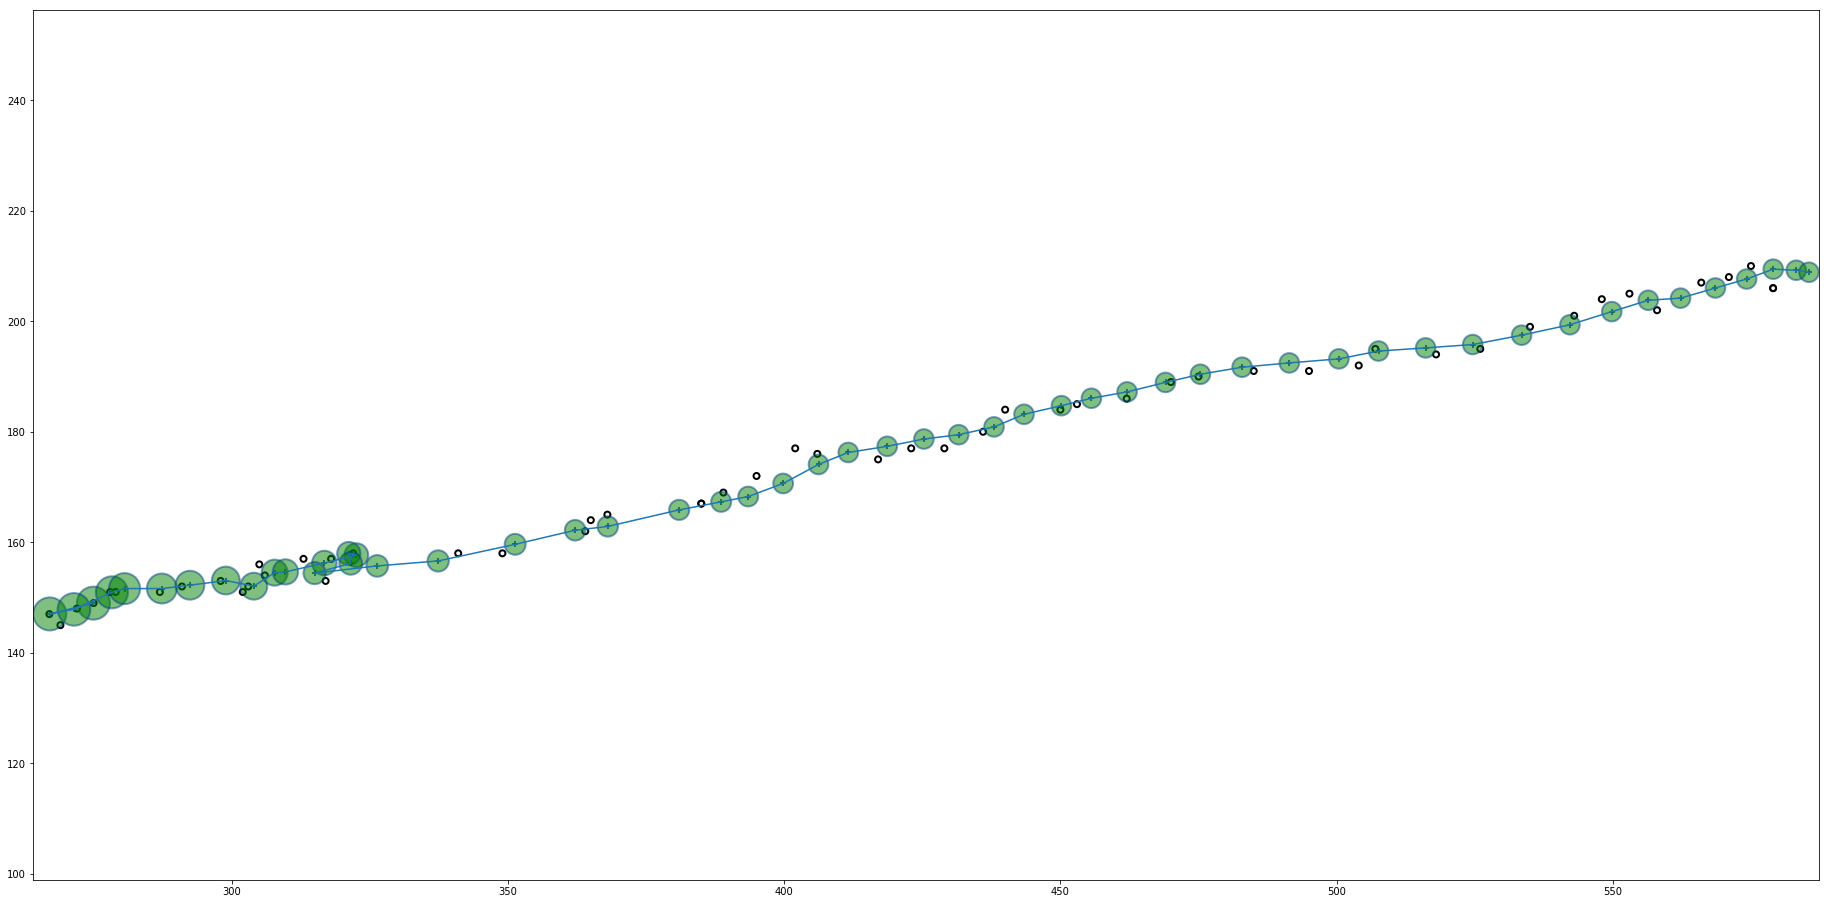

In [13]:
filter_and_plot('output/0077/77_centers.csv')

initialized P = 
[[100.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0. 100.]]
initialized R = 
[[1. 0.]
 [0. 1.]]
initialized Q = 
[[2.5e-05 5.0e-05 5.0e-05 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 2.5e-05 5.0e-05 5.0e-05]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]]
no control function B: 0.0


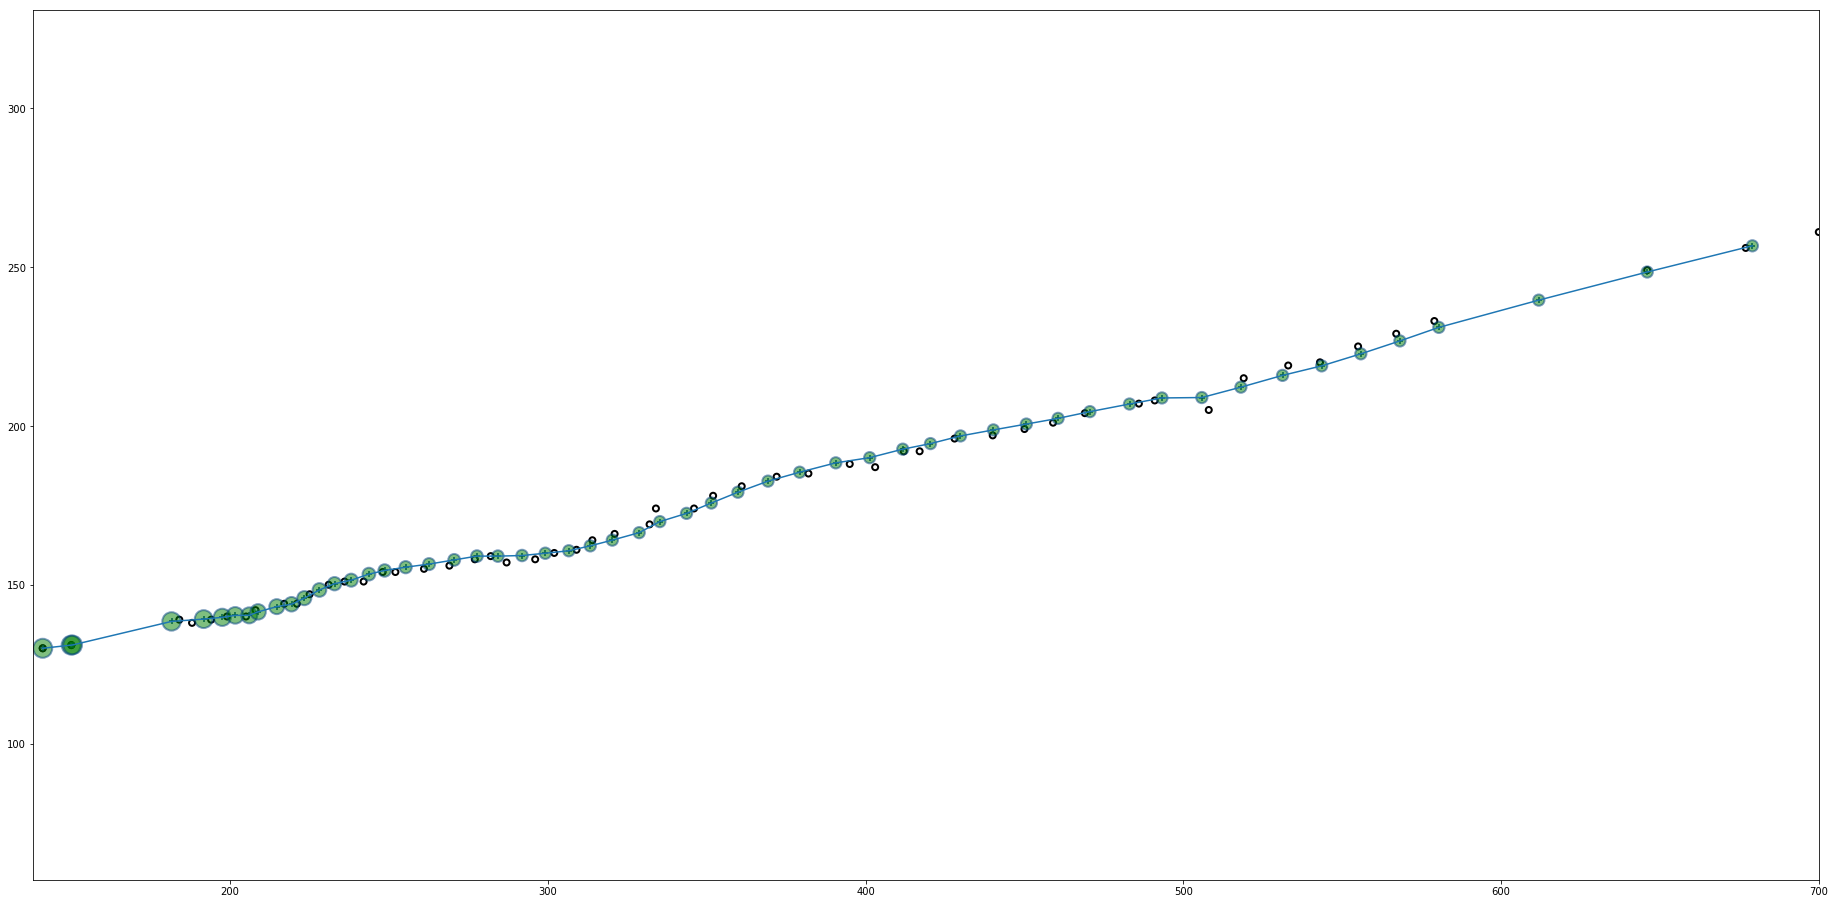

In [14]:
filter_and_plot('output/0082/82_centers.csv')

initialized P = 
[[100.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0. 100.]]
initialized R = 
[[1. 0.]
 [0. 1.]]
initialized Q = 
[[2.5e-05 5.0e-05 5.0e-05 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 2.5e-05 5.0e-05 5.0e-05]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]]
no control function B: 0.0


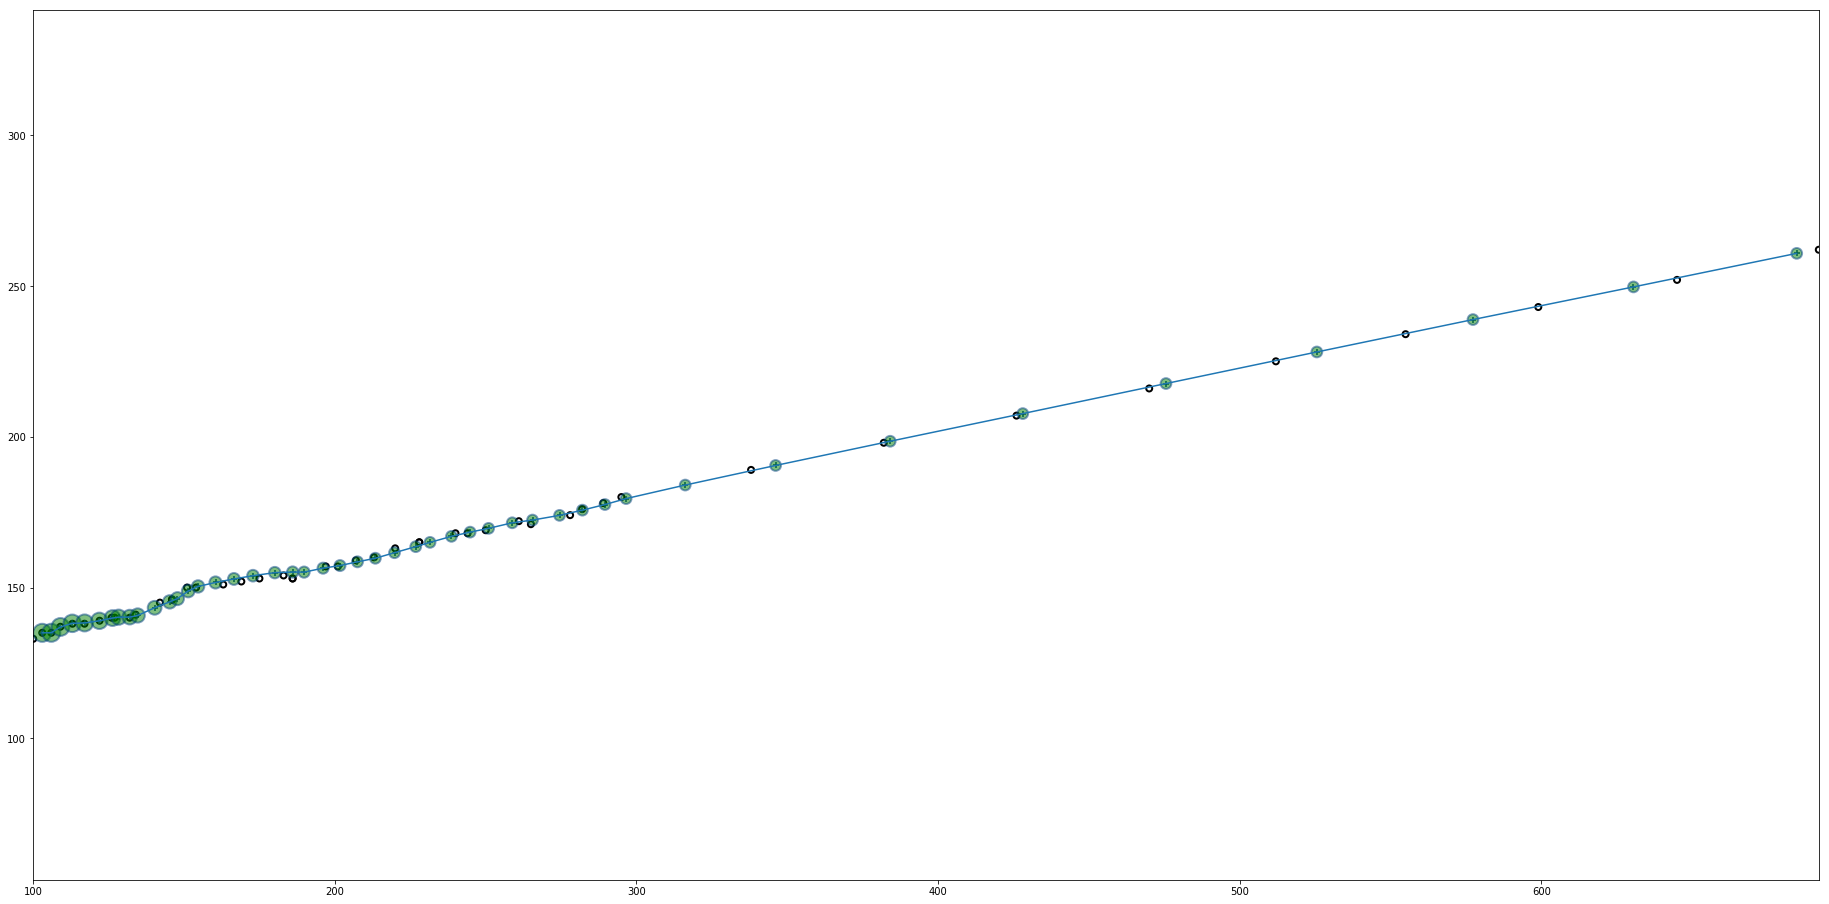

In [15]:
filter_and_plot('output/0097/97_centers.csv')

initialized P = 
[[100.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0. 100.]]
initialized R = 
[[1. 0.]
 [0. 1.]]
initialized Q = 
[[2.5e-05 5.0e-05 5.0e-05 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 2.5e-05 5.0e-05 5.0e-05]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]]
no control function B: 0.0


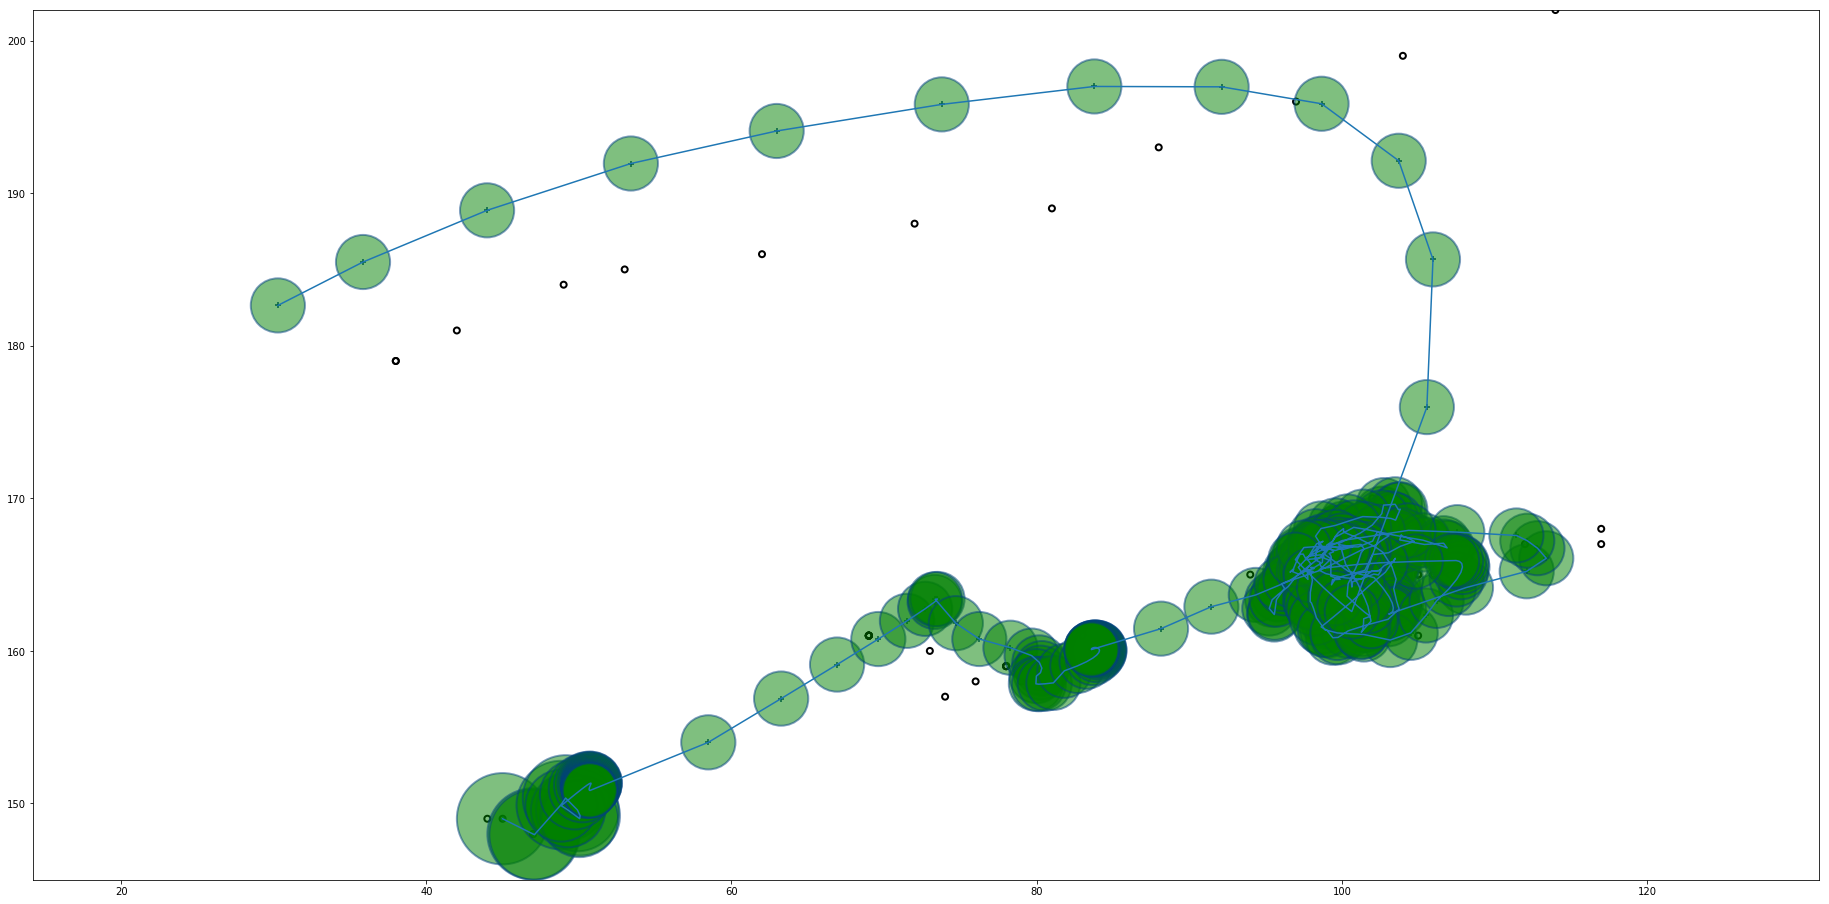

In [16]:
filter_and_plot('output/0107/107_centers.csv')

initialized P = 
[[100.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0. 100.]]
initialized R = 
[[1. 0.]
 [0. 1.]]
initialized Q = 
[[2.5e-05 5.0e-05 5.0e-05 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 2.5e-05 5.0e-05 5.0e-05]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]]
no control function B: 0.0


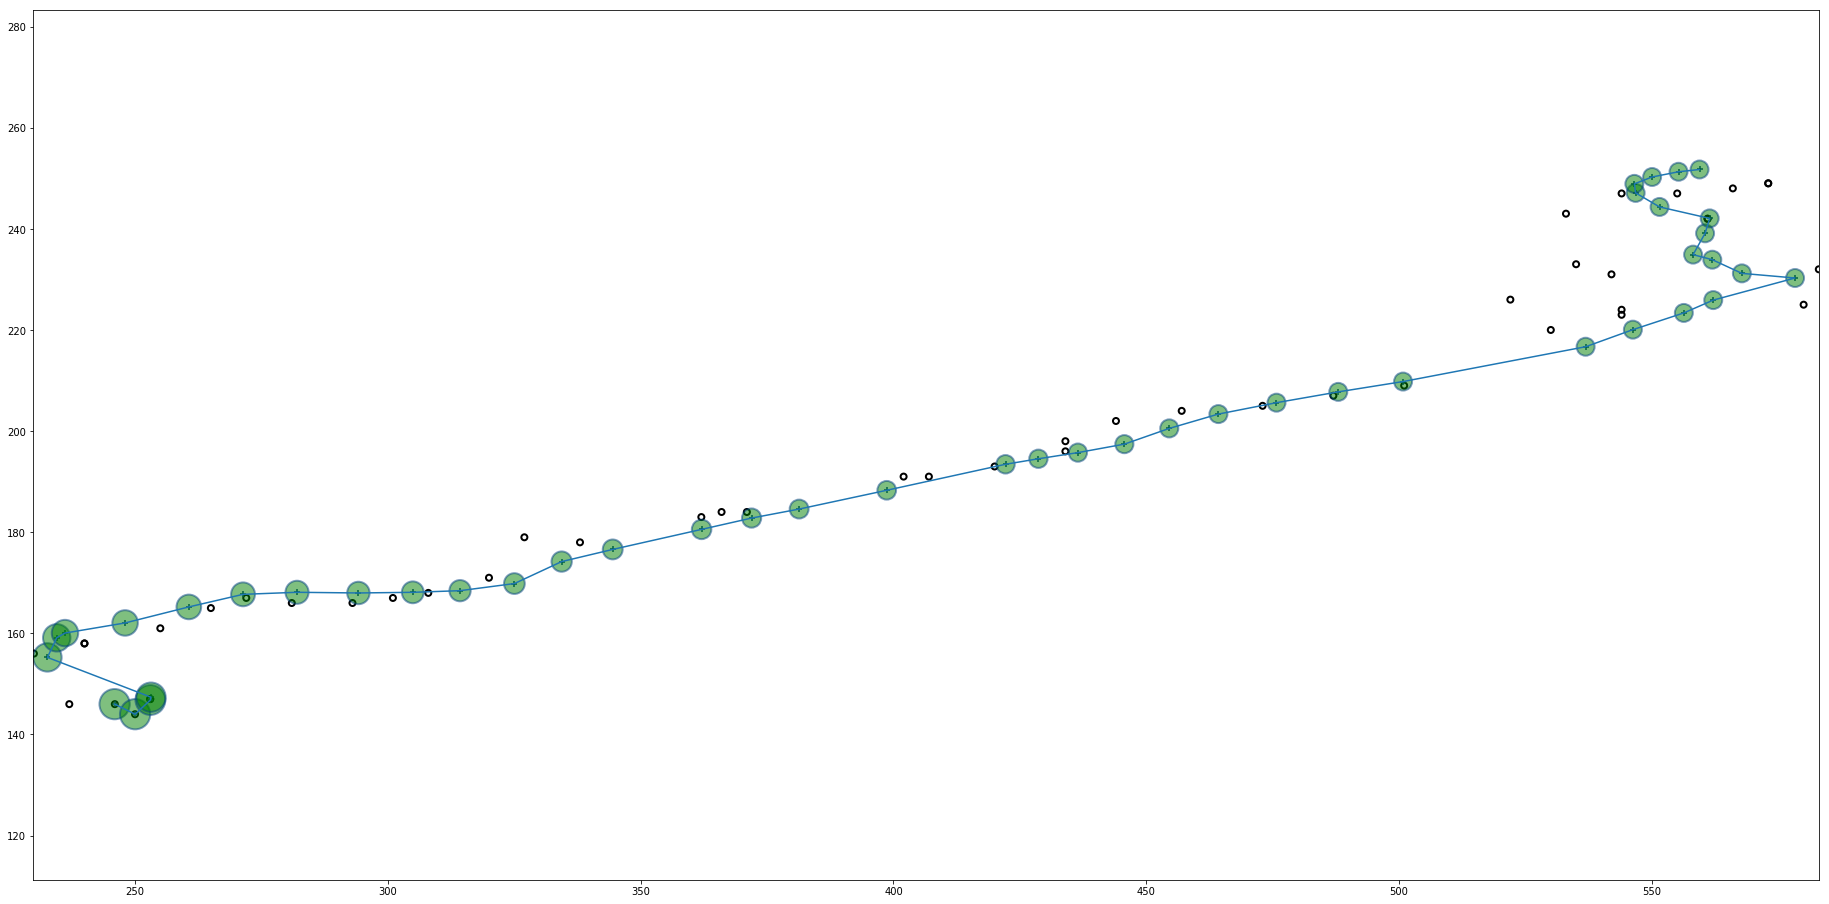

In [17]:
filter_and_plot('output/0115/115_centers.csv')

initialized P = 
[[100.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0. 100.]]
initialized R = 
[[1. 0.]
 [0. 1.]]
initialized Q = 
[[2.5e-05 5.0e-05 5.0e-05 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-05 1.0e-04 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 2.5e-05 5.0e-05 5.0e-05]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-05 1.0e-04 1.0e-04]]
no control function B: 0.0


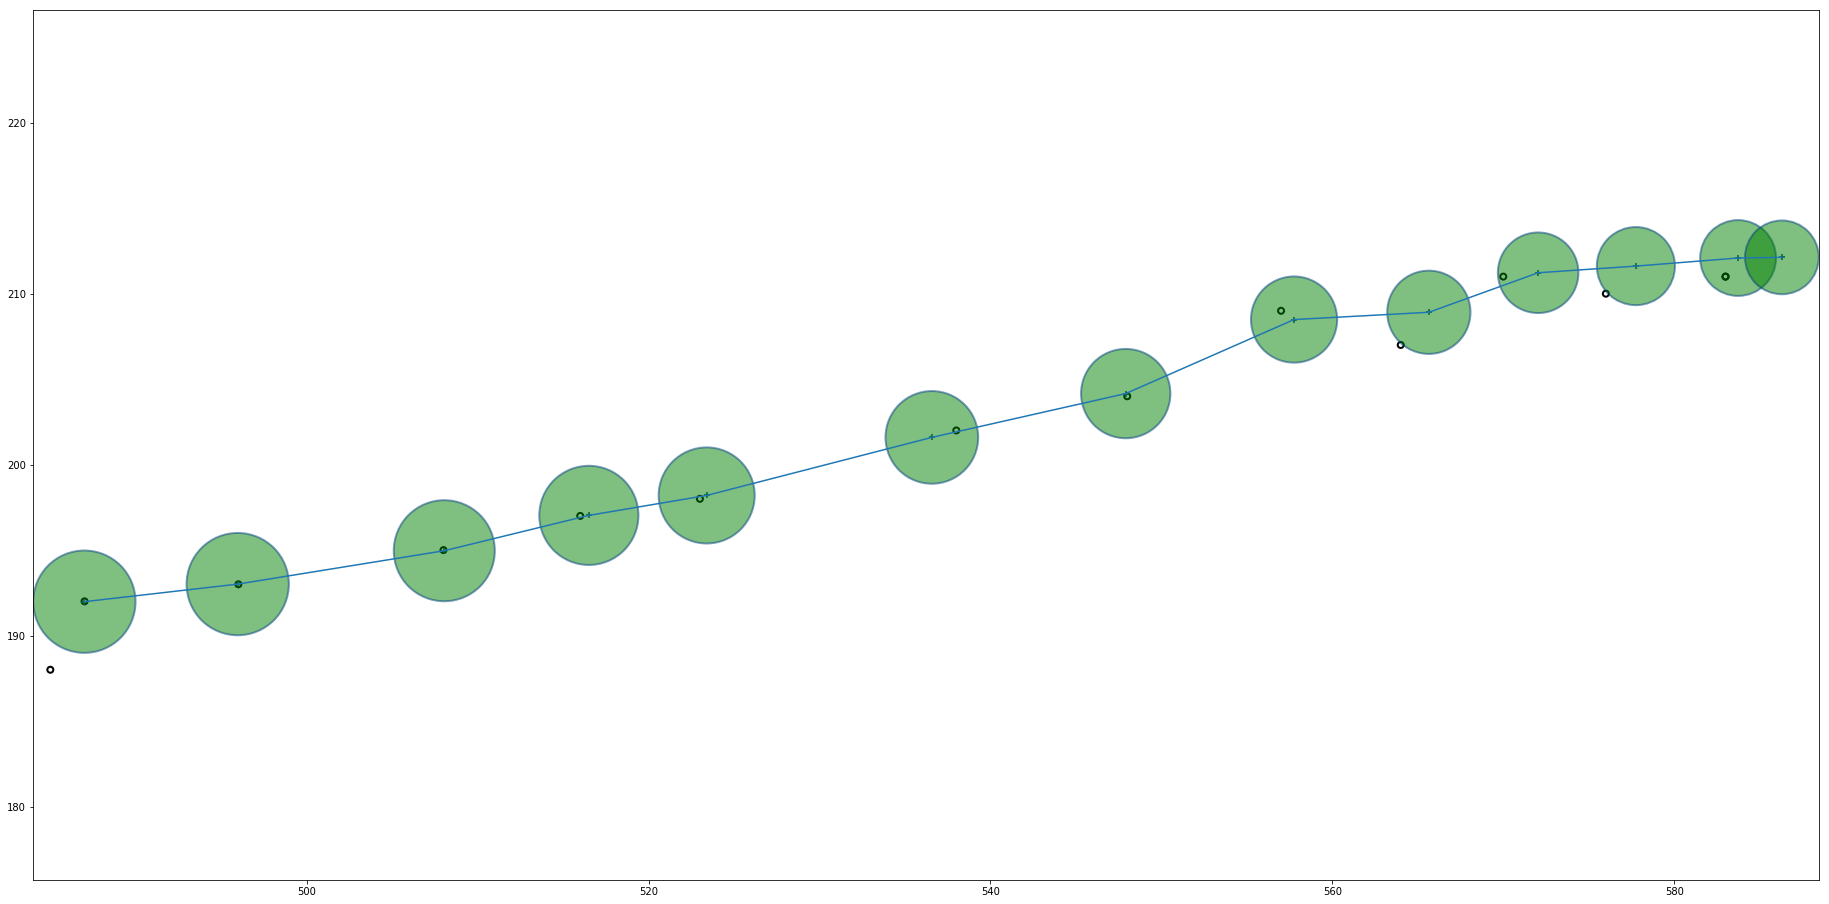

In [18]:
filter_and_plot('output/0117/117_centers.csv')

In [ ]:
filter_and_plot('output/0132/132_centers.csv')

In [ ]:
filter_and_plot('output/0140/140_centers.csv')

In [ ]:
filter_and_plot('output/0159/159_centers.csv')

In [ ]:
filter_and_plot('output/0163/163_centers.csv')

In [ ]:
filter_and_plot('output/0171/171_centers.csv')

In [ ]:
filter_and_plot('output/0172/172_centers.csv')

In [ ]:
filter_and_plot('output/0196/196_centers.csv')

In [ ]:
filter_and_plot('output/0202/202_centers.csv')

In [ ]:
filter_and_plot('output/0204/204_centers.csv')